<a href="https://colab.research.google.com/github/yingzibu/a_inhibitor_design/blob/main/examples/LSTM_VAE_with_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# https://github.com/bayeslabs/genmol/blob/master/genmol/vae/data.py

# https://github.com/aspuru-guzik-group/selfies/blob/master/examples/vae_example/chemistry_vae.py

In [143]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [144]:
! pip install PyTDC --quiet
! pip install selfies

In [1]:
from tdc.generation import MolGen
import selfies as sf
from tqdm import tqdm
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader

data = MolGen(name = 'ZINC')
split = data.get_split()
train = split['train']
valid = split['valid']
test = split['test']

Found local copy...
Loading...
Done!


In [11]:
from tdc import Oracle
qed = Oracle(name='QED')
sa = Oracle(name='SA')

In [2]:
import pandas as pd

def convert_with_qed_sa(train):
    smile_list = train['smiles'].tolist()
    qed_list = qed(smile_list)
    sa_list = sa(smile_list)

    df = pd.DataFrame()
    df['smiles'] = pd.DataFrame(smile_list)
    df['qed'] = pd.DataFrame(qed_list)
    df['sa'] = pd.DataFrame(sa_list)
    df = df.reset_index(drop=True)
    return df

def gen_loader(train):
    df = convert_with_qed_sa(train)
    loader = DataLoader(dataset(df, device=device), batch_size=len(df),
                        shuffle=True, num_workers=n_workers,
                        collate_fn=my_collate)
    return loader


# train_loader = DataLoader(dataset(df, device=device),
#                       batch_size=n_batch,
#                       shuffle=True, num_workers=n_workers,
#                       collate_fn=my_collate)

In [3]:
from torch.utils.data import DataLoader, Dataset

class dataset(Dataset):
    def __init__(self, df, device):
        super(dataset, self).__init__()

        self.df = df
        self.device = device
        self.len = len(df)

    def __getitem__(self, idx):
        label = [self.df['qed'][idx], self.df['sa'][idx]]

        label = torch.tensor(label, dtype=torch.float32).to(self.device)

        smi = self.df['smiles'][idx]
        tensor = string2tensor(smi, device=self.device)
        # x_padded = pad_sequence(tensor, batch_first=True, padding_value=c2i['<pad>'])

        return [tensor, label]
        # tensor = [string2tensor(string)]

    def __len__(self): return self.len


In [28]:
from torch.nn.utils.rnn import pack_sequence
from torch.utils.data import DataLoader

def my_collate(batch):
    # batch contains a list of tuples of structure (sequence, target)
    data = [item[0] for item in batch]
    data = pad_sequence(data, batch_first=True, padding_value=c2i['<pad>'])
    # targets = [item[1] for item in batch]
    targets = [item[1] for item in batch]
    targets = torch.stack(targets)
    return (data, targets)


# train_loader = DataLoader(dataset(df, device=device),
#                       batch_size=n_batch,
#                       shuffle=True, num_workers=n_workers,
#                       collate_fn=my_collate)


In [249]:
from torch.nn.utils.rnn import pad_sequence
params = {'batch_size': n_batch, 'shuffle': True,
          'drop_last': False, 'num_workers': n_workers}
def pad_collate(batch):
    lengths = [len(x) for x in batch[0]]
    batch_tensor = [torch.tensor(x, dtype=torch.long) for x in batch[0]]
    x_padded = pad_sequence(batch_tensor, batch_first=True,
                            padding_value=c2i['<pad>'])

    return x_padded, lengths

# train_loader = DataLoader(a, **params)
for i, j in loader:
    i, j

[44, 2]

In [189]:
def get_dataloader(model, train_data, collate_fn=None, shuffle=True):
    if collate_fn is None:
        collate_fn = get_collate_fn(model)
        # print(collate_fn)
        # print('here?')
    return DataLoader(train_data, batch_size=n_batch, shuffle=shuffle, num_workers=n_workers, collate_fn=collate_fn)

def get_collate_fn(model):
    device = get_collate_device(model)

    def collate(train_data):
        # print(type(train_data)) # dataloader
        train_data.sort(key=len, reverse=True)
        for i in train_data:
            print(i)
            # break
        tensors = [string2tensor(string, device=device) for string in train_data]
        return tensors

    return collate

In [190]:
get_dataloader(model, test['smiles'], shuffle=True)

In [ ]:
small_smiles = []
for benzene in tqdm(train['smiles']):
    try:
        benzene_sf = sf.encoder(benzene)  # [C][=C][C][=C][C][=C][Ring1][=Branch1]
        benzene_smi = sf.decoder(benzene_sf)  # C1=CC=CC=C1
        length = sf.len_selfies(benzene_sf)  # 8
        if length < 20:
            small_smiles.append(benzene)
    except sf.EncoderError:
        pass  # sf.encoder error!
    except sf.DecoderError:
        pass  # sf.decoder error!


    # symbols_benzene = list(sf.split_selfies(benzene_sf))

In [ ]:
# del len
alphabet= sf.get_alphabet_from_selfies(small_smiles)
alphabet.add("[nop]", '[bos]', '[eos]', '[unk]')
len(alphabet)

In [5]:
import torch
chars = set()
for string in train['smiles']:
    chars.update(string)
all_sys =  ['<pad>', '<bos>', '<eos>', '<unk>'] + sorted(list(chars))
vocab = all_sys
c2i = {c: i for i, c in enumerate(all_sys)}
i2c = {i: c for i, c in enumerate(all_sys)}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vector = torch.eye(len(c2i))

def char2id(char):
    if char not in c2i:
        return c2i['<unk>']
    else:
        return c2i[char]


def id2char(id):
    if id not in i2c:
        return i2c[c2i['<unk>']]
    else:
        return i2c[id]

def string2ids(string,add_bos=False, add_eos=False):
    ids = [char2id(c) for c in string]
    if add_bos:
        ids = [c2i['<bos>']] + ids
    if add_eos:
        ids = ids + [c2i['<eos>']]
    return ids
def ids2string(ids, rem_bos=True, rem_eos=True):
    # print(ids)
    if isinstance(ids[0], list): ids = ids[0]
    if len(ids) == 0:
        return ''
    if rem_bos and ids[0] == c2i['<bos>']:
        ids = ids[1:]
    # delete <eos>
    if rem_eos:
        for i, id in enumerate(ids):
            # print(i, id)
            if id == c2i['<eos>']:
                ids = ids[:i]
                break

    # if rem_eos and ids[-1] == c2i['<eos>']:
    #     ids = ids[:-1]

    string = ''.join([id2char(id) for id in ids])
    return string

def string2tensor(string, device='model'):
    ids = string2ids(string, add_bos=True, add_eos=True)
    tensor = torch.tensor(ids, dtype=torch.long,device=device if device == 'model' else device)
    return tensor

# tensor = [string2tensor(string, device=device) for string in train['smiles']]


vector = torch.eye(len(c2i))  # (alphabet_len, alphabet_len)

In [377]:
# ids2string(l)

In [6]:
# -*- coding: utf-8 -*-
import torch
import torch.nn as nn
import torch.nn.functional as F

q_bidir = True
q_d_h = 256
q_n_layers = 1
q_dropout = 0.5
d_n_layers = 3
d_dropout = 0
d_z = 128 * 2 ############################################
d_d_h = 512
# from data import *

###########for classifier#################
h_dims = [128, 64]
out_dim = 2
dims_classifier = [d_z, h_dims, out_dim]
pred_loss_percent = 0.2
MASK = -100 # if there is no label info


class Regressor(nn.Module):
    """
    simple regression, for prediction using
    latent space of dim [batch_size, z_dim]
    """
    def __init__(self, dims):
        """
        :param dims [in_dim, h_dims, out_dim]
            in_dim: input dim
            h_dims: a list of hidden dims
            out_dim: output dim
        """
        super(Regressor, self).__init__()
        [in_dim, h_dims, out_dim] = dims
        self.dims = dims

        neurons = [in_dim, *h_dims]
        linear_layers = [nn.Linear(
            neurons[i-1], neurons[i]
            ) for i in range(1, len(neurons))]

        self.hidden = nn.ModuleList(linear_layers)
        self.final = nn.Linear(h_dims[-1], out_dim)

    def forward(self, x, y, loss_func=nn.MSELoss()):
        # print('classifier in x dim:', x.shape) [bs, h_dim]
        for layer in self.hidden:
            x = F.relu(layer(x))
            # print(x.shape) [batch_size, h_dim[-1]]
        x = self.final(x)
        mask = y == MASK
        # print(x.shape) # [bs, y_dim]
        # loss_func = nn.MSELoss()
        classify_loss  = loss_func(x[~mask], y[~mask])
        return x, classify_loss

    # def loss_function(self): return nn.MSELoss()

class VAE(nn.Module):
    def __init__(self,vocab,vector):
        super().__init__()
        self.vocabulary = vocab
        self.vector = vector

        n_vocab, d_emb = len(vocab), vector.size(1)
        self.x_emb = nn.Embedding(n_vocab, d_emb, c2i['<pad>'])
        self.x_emb.weight.data.copy_(vector)

        #ENCODER

        self.encoder_rnn = nn.GRU(d_emb,q_d_h,num_layers=q_n_layers,
                batch_first=True,dropout=q_dropout if q_n_layers > 1 else 0,
                bidirectional=q_bidir)
        q_d_last = q_d_h * (2 if q_bidir else 1)
        self.q_mu = nn.Linear(q_d_last, d_z)
        self.q_logvar = nn.Linear(q_d_last, d_z)



        # Decoder
        self.decoder_rnn = nn.GRU(d_emb + d_z,d_d_h,num_layers=d_n_layers,batch_first=True,dropout=d_dropout if d_n_layers > 1 else 0)
        self.decoder_latent = nn.Linear(d_z, d_d_h)
        self.decoder_fullyc = nn.Linear(d_d_h, n_vocab)

        # Classifier
        self.classifier = Regressor(dims_classifier)

        # Grouping the model's parameters
        self.encoder = nn.ModuleList([self.encoder_rnn,self.q_mu,self.q_logvar])
        self.decoder = nn.ModuleList([self.decoder_rnn,self.decoder_latent,self.decoder_fullyc])
        self.vae = nn.ModuleList([self.x_emb,self.encoder,self.decoder, self.classifier])



    @property
    def device(self):
        return next(self.parameters()).device

    def string2tensor(self, string, device='model'):
        ids = string2ids(string, add_bos=True, add_eos=True)
        tensor = torch.tensor(ids, dtype=torch.long,
                              device=self.device if device == 'model' else device)
        return tensor

    def tensor2string(self, tensor):
        ids = tensor.tolist()
        string = ids2string(ids, rem_bos=True, rem_eos=True)
        return string

    def forward(self,x, y=None):
        z, mu, kl_loss = self.forward_encoder(x)
        if y != None: y_hat, classify_loss = self.classifier(mu, y)
        else: classify_loss = 0
        _, recon_loss = self.forward_decoder(x, z)
        # print("forward")
        return kl_loss, recon_loss, classify_loss

    def reconstruct(self, x):
        z, _, _ = self.forward_encoder(x)
        y, _ = self.forward_decoder(x, z)
        return y

    def reconstruct_mu(self, x):
        _, mu, _ = self.forward_encoder(x)
        y, _ = self.forward_decoder(x, mu)
        return y


    def forward_encoder(self, x):
        x = [self.x_emb(i_x) for i_x in x]
        x = nn.utils.rnn.pack_sequence(x)
        _, h = self.encoder_rnn(x, None)
        h = h[-(1 + int(self.encoder_rnn.bidirectional)):]
        h = torch.cat(h.split(1), dim=-1).squeeze(0)
        mu, logvar = self.q_mu(h), self.q_logvar(h)
        eps = torch.randn_like(mu)
        z = mu + (logvar / 2).exp() * eps
        kl_loss = 0.5 * (logvar.exp() + mu ** 2 - 1 - logvar).sum(1).mean()
        return z, mu, kl_loss

    def forward_decoder(self,x, z):
        lengths = [len(i_x) for i_x in x]
        x = nn.utils.rnn.pad_sequence(x, batch_first=True, padding_value= c2i['<pad>'])
        x_emb = self.x_emb(x)
        z_0 = z.unsqueeze(1).repeat(1, x_emb.size(1), 1)
        x_input = torch.cat([x_emb, z_0], dim=-1)
        x_input = nn.utils.rnn.pack_padded_sequence(x_input, lengths, batch_first=True)
        h_0 = self.decoder_latent(z)
        h_0 = h_0.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
        output, _ = self.decoder_rnn(x_input, h_0)
        output, _ = nn.utils.rnn.pad_packed_sequence(output, batch_first=True)
        y = self.decoder_fullyc(output)

        recon_loss = F.cross_entropy(y[:, :-1].contiguous().view(-1, y.size(-1)),
                                    x[:, 1:].contiguous().view(-1),
                                     ignore_index= c2i['<pad>'])
        return y, recon_loss


    def sample_z_prior(self,n_batch):
        return torch.randn(n_batch,self.q_mu.out_features,
                           device= self.x_emb.weight.device)

    def sample(self,n_batch, max_len=100, z=None, temp=1.0):
        with torch.no_grad():
            if z is None: z = self.sample_z_prior(n_batch)

            z = z.to(self.device)
            z_0 = z.unsqueeze(1)
            h = self.decoder_latent(z)
            h = h.unsqueeze(0).repeat(self.decoder_rnn.num_layers, 1, 1)
            w = torch.tensor(c2i['<bos>'], device=self.device).repeat(n_batch)
            x = torch.tensor([c2i['<pad>']], device=device).repeat(n_batch, max_len)
            x[:, 0] = c2i['<bos>']
            end_pads = torch.tensor([max_len], device=self.device).repeat(n_batch)
            eos_mask = torch.zeros(n_batch, dtype=torch.uint8, device=self.device)

            for i in range(1, max_len):
                x_emb = self.x_emb(w).unsqueeze(1)
                x_input = torch.cat([x_emb, z_0], dim=-1)

                o, h = self.decoder_rnn(x_input, h)
                y = self.decoder_fullyc(o.squeeze(1))
                y = F.softmax(y / temp, dim=-1)

                w = torch.multinomial(y, 1)[:, 0]
                x[~eos_mask, i] = w[~eos_mask]
                i_eos_mask = ~eos_mask & (w == c2i['<eos>'])
                end_pads[i_eos_mask] = i + 1
                eos_mask = eos_mask | i_eos_mask

                new_x = []
                for i in range(x.size(0)):
                    new_x.append(x[i, :end_pads[i]])

        return [self.tensor2string(i_x) for i_x in new_x]


In [7]:
# -*- coding: utf-8 -*-
from torch.optim.lr_scheduler import _LRScheduler
import torch.optim as optim
from torch.utils.data import DataLoader
from torch.nn.utils import clip_grad_norm_
import math
import numpy as np
from collections import UserList, defaultdict
n_last = 1000
n_batch = 512
kl_start = 0
kl_w_start = 0.0
kl_w_end = 1.0 ###############################
n_epoch = 500
n_workers = 0

clip_grad  = 50
lr_start = 0.003
lr_n_period = 10
lr_n_mult = 1
lr_end = 3 * 1e-4
lr_n_restarts = 1 ###############################

# from data import *

def _n_epoch():
    return sum(lr_n_period * (lr_n_mult ** i) for i in range(lr_n_restarts))


def recon_test(model):
    test_smiles = [fed]
    te = [string2tensor(string, device=device) for string in test_smiles]

    y = model.reconstruct(te)
    y_mu = model.reconstruct_mu(te)

    temp = 1
    y = F.softmax(y / temp, dim=-1)
    y = torch.argmax(y, dim=-1)
    l = y.cpu().detach().tolist()

    y_mu = torch.argmax(F.softmax(y_mu/temp, dim=-1), dim=-1)
    l_mu = y_mu.cpu().detach().tolist()

    # print('true: ', model.string2tensor(fed))
    # print('pred with noise:', l)
    # print('pred with mu:   ', l_mu)
    smi_recon = [ids2string(ids, rem_bos=True, rem_eos=True) for ids in l]
    smi_recon_mu = [ids2string(ids, rem_bos=True, rem_eos=True) for ids in l_mu]
    for i, j in zip(smi_recon, smi_recon_mu):
        # print(i)
        print('fed smi    :', fed)
        print('pred_z  smi:', i)
        print('pred_mu smi:', j)
        try:
            mol = m(i)
            if mol != None: display(mol)
            else: print('pred_z  mol is none, cannot recon')
        except: print('invalid pred smi from z, cannot recon')
        try:
            mol = m(j)
            if mol != None: display(mol)
            else: print('pred_mu mol is none, cannot recon')
        except: print('invalid pred smi from mu, cannot recon')



def _train_epoch(model, epoch, train_loader, kl_weight, optimizer=None):
    if optimizer is None:
        model.eval()
    else:
        model.train()

    kl_loss_values = CircularBuffer(n_last)
    recon_loss_values = CircularBuffer(n_last)
    loss_values = CircularBuffer(n_last)
    classifier_loss_values = CircularBuffer(n_last)
    for i, (x, label) in tqdm(enumerate(train_loader), total=len(train_loader)):

        # input_batch = tuple(data.to(device) for data in x)

    #forward
        kl_loss, recon_loss, classifier_loss = model(x, label)
        loss = kl_weight * kl_loss + recon_loss + \
                pred_loss_percent * classifier_loss

    #backward
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            clip_grad_norm_(get_optim_params(model), clip_grad)
            optimizer.step()

        kl_loss_values.add(kl_loss.item())
        recon_loss_values.add(recon_loss.item())
        classifier_loss_values.add(classifier_loss.item())
        loss_values.add(loss.item())
        lr = (optimizer.param_groups[0]['lr'] if optimizer is not None else None)

    #update train_loader
        kl_loss_value = kl_loss_values.mean()
        recon_loss_value = recon_loss_values.mean()
        classifier_loss_value = classifier_loss_values.mean()
        loss_value = loss_values.mean()
        postfix = [f'loss={loss_value:.5f}',f'(kl={kl_loss_value:.5f}',
                   f'recon={recon_loss_value:.5f})',
                   f'classify={classifier_loss_value:.5f}',
                   f'klw={kl_weight:.5f} lr={lr:.5f}']
        if i % (len(train_loader)/3) == 0 and i!= 0:
            print(f'Epoch {epoch}: {i}/{len(train_loader)} |', postfix)
    postfix = {'epoch': epoch,'kl_weight': kl_weight,'lr': lr,
               'kl_loss': kl_loss_value,'recon_loss': recon_loss_value,
               'loss': loss_value,'mode': 'Eval' \
               if optimizer is None else 'Train'}
    sample_smis = sample.take_samples(model, n_batch)
    valid_rate = visual_mols(sample_smis)

    recon_test(model)
    # print(postfix)
    return postfix, valid_rate

def _train(model, train_loader, val_loader=None, logger=None):
    optimizer = optim.Adam(get_optim_params(model),lr= lr_start)

    lr_annealer = CosineAnnealingLRWithRestart(optimizer)
    valid_rate_best = 0
    model.zero_grad()
    for epoch in range(n_epoch):

        kl_annealer = KLAnnealer(n_epoch)
        kl_weight = kl_annealer(epoch)
        postfix, valid_rate = _train_epoch(model, epoch, train_loader, kl_weight, optimizer)
        if valid_rate > valid_rate_best:
            valid_rate_best = valid_rate
            if valid_rate > 0.5:
                print('save model ckpt.pt')
                torch.save(model.state_dict(), 'ckpt.pt')
        elif valid_rate < 0.75 * valid_rate_best:
            print('valid rate drop, early stop')
            break
        lr_annealer.step()

def fit(model, train_data, val_data=None, classifier=None):
    logger = Logger() if False is not None else None
    if classifier == None:

        train_loader = get_dataloader(model, train_data, shuffle=True)

        val_loader = None if val_data is None else get_dataloader(model, val_data, shuffle=False)
    else:
        train_loader = train_data
        val_loader = val_data

    _train(model, train_loader, val_loader, logger)
    return model

# def fit_(model, train_loader)


def get_collate_device(model):
    return model.device



def get_optim_params(model):
    return (p for p in model.parameters() if p.requires_grad)

class KLAnnealer:
    def __init__(self,n_epoch):
        self.i_start = kl_start
        self.w_start = kl_w_start
        self.w_max = kl_w_end
        self.n_epoch = n_epoch


        self.inc = (self.w_max - self.w_start) / (self.n_epoch - self.i_start)

    def __call__(self, i):
        k = (i - self.i_start) if i >= self.i_start else 0
        return self.w_start + k * self.inc


class CosineAnnealingLRWithRestart(_LRScheduler):
    def __init__(self , optimizer):
        self.n_period = lr_n_period
        self.n_mult = lr_n_mult
        self.lr_end = lr_end

        self.current_epoch = 0
        self.t_end = self.n_period

        # Also calls first epoch
        super().__init__(optimizer, -1)

    def get_lr(self):
        return [self.lr_end + (base_lr - self.lr_end) *
                (1 + math.cos(math.pi * self.current_epoch / self.t_end)) / 2
                for base_lr in self.base_lrs]

    def step(self, epoch=None):
        if epoch is None:
            epoch = self.last_epoch + 1
        self.last_epoch = epoch
        self.current_epoch += 1

        for param_group, lr in zip(self.optimizer.param_groups, self.get_lr()):
            param_group['lr'] = lr

        if self.current_epoch == self.t_end:
            self.current_epoch = 0
            self.t_end = self.n_mult * self.t_end


class CircularBuffer:
    def __init__(self, size):
        self.max_size = size
        self.data = np.zeros(self.max_size)
        self.size = 0
        self.pointer = -1

    def add(self, element):
        self.size = min(self.size + 1, self.max_size)
        self.pointer = (self.pointer + 1) % self.max_size
        self.data[self.pointer] = element
        return element

    def last(self):
        assert self.pointer != -1, "Can't get an element from an empty buffer!"
        return self.data[self.pointer]

    def mean(self):
        return self.data.mean()


class Logger(UserList):
    def __init__(self, data=None):
        super().__init__()
        self.sdata = defaultdict(list)
        for step in (data or []):
            self.append(step)

    def __getitem__(self, key):
        if isinstance(key, int):
            return self.data[key]
        elif isinstance(key, slice):
            return Logger(self.data[key])
        else:
            ldata = self.sdata[key]
            if isinstance(ldata[0], dict):
                return Logger(ldata)
            else:
                return ldata

    def append(self, step_dict):
        super().append(step_dict)
        for k, v in step_dict.items():
            self.sdata[k].append(v)

In [8]:
# from tqdm import tqdm
import pandas as pd
n_samples = 3000
n_jobs = 1
max_len = 100

class sample():
    def take_samples(model,n_batch, max_len=max_len):
        n = n_samples
        samples = []
        with tqdm(total=n_samples, desc='Generating samples') as T:
            while n > 0:
                current_samples = model.sample(min(n, n_batch), max_len)
                samples.extend(current_samples)
                n -= len(current_samples)
                T.update(len(current_samples))
        samples = pd.DataFrame(samples, columns=['SMILES'])
        return samples

from IPython.display import display
from rdkit import Chem
from rdkit import RDLogger
RDLogger.DisableLog('rdApp.*')

m = Chem.MolFromSmiles
def visual_mols(sample_smis):

    valid_smis = []
    for i in sample_smis.SMILES:
        try:
            mol = m(i)
            if mol != None: valid_smis.append(i)
        except: pass
    valid_rate = len(valid_smis) / len(sample_smis)
    unique_smis = [*set(valid_smis)]
    unique_rate = len(unique_smis) / len(sample_smis)

    print(f'valid {valid_rate*100:.3f}%  |  unique {unique_rate*100:.3f}%')

    from rdkit.Chem.Draw import IPythonConsole, MolsToGridImage

    MAX_GRID = 16
    img = MolsToGridImage(
        [m(smi) for smi in unique_smis[:MAX_GRID]],
        molsPerRow=int(math.sqrt(MAX_GRID)),
        subImgSize=(250, 150),  returnPNG=False)
    display(img)
    return valid_rate

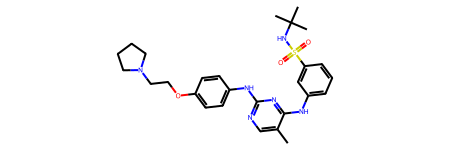

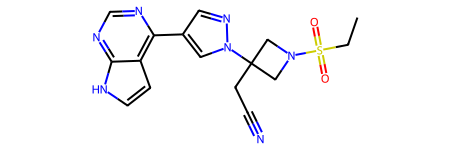

(None, None)

In [223]:
fed = 'Cc1cnc(nc1Nc1cccc(c1)S(=O)(=O)NC(C)(C)C)Nc1ccc(cc1)OCCN1CCCC1'
bar = 'CCS(=O)(=O)N1CC(C1)(CC#N)N2C=C(C=N2)C3=C4C=CNC4=NC=N3'
display(m(fed)), display(m(bar))

In [392]:
model = VAE(vocab, vector).to(device)

model.string2tensor(fed)



In [382]:
test_smiles = [fed]
te = [string2tensor(string, device=device) for string in test_smiles]

y = model.reconstruct(te)
temp = 1
y_ = F.softmax(y / temp, dim=-1)
y_here = torch.argmax(y_, dim=-1)
y_here.shape
l = y_here.cpu().detach().tolist()
print('true: ', model.string2tensor(fed))
print('pred:', l)
smi_recon = [ids2string(ids, rem_bos=True, rem_eos=True) for ids in l]
for i in smi_recon:
    print(i)

true:  tensor([ 1, 21, 32, 10, 32, 34, 32,  5, 34, 32, 10, 25, 32, 10, 32, 32, 32, 32,
         5, 32, 10,  6, 28,  5, 18, 26,  6,  5, 18, 26,  6, 25, 21,  5, 21,  6,
         5, 21,  6, 21,  6, 25, 32, 10, 32, 32, 32,  5, 32, 32, 10,  6, 26, 21,
        21, 25, 10, 21, 21, 21, 21, 10,  2], device='cuda:0')
pred: [[10, 10, 10, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 21, 36, 36, 36, 36, 36, 36, 36, 36, 36, 36, 21, 21, 21, 21, 21, 21, 21]]
111CCCCCCCCCCCrrrrrrrrrrrCCCCCCCCCCCCCCCCCCCCCrrrrrrrrrrCCCCCCC


In [67]:
n_batch

512

In [ ]:
model = VAE(vocab,vector).to(device)
# fit(model, train['smiles'])
fit(model, train_loader, val_data=None, classifier=True)


In [68]:
import shutil
# shutil.move("/content/ckpt.pt", "/content/drive/MyDrive/A_MODEL/LSTM_VAE_char2id/ckpt.pt")


import pandas as pd

def convert_with_qed_sa(train):
    smile_list = train['smiles'].tolist()
    print('---> calculating QED')
    qed_list = qed(smile_list)
    print('---> calculating SA ')
    sa_list = sa(smile_list)

    df = pd.DataFrame()
    df['smiles'] = pd.DataFrame(smile_list)
    df['qed'] = pd.DataFrame(qed_list)
    df['sa'] = pd.DataFrame(sa_list)
    df = df.reset_index(drop=True)
    return df

def gen_loader(train):

    from torch.nn.utils.rnn import pad_sequence
    from torch.utils.data import DataLoader
    def my_collate(batch):
        # batch contains a list of tuples of structure (sequence, target)
        data = [item[0] for item in batch]
        data = pad_sequence(data, batch_first=True, padding_value=c2i['<pad>'])
        # targets = [item[1] for item in batch]
        targets = [item[1] for item in batch]
        targets = torch.stack(targets)
        return (data, targets)
    df = convert_with_qed_sa(train)
    loader = DataLoader(dataset(df, device=device), batch_size=n_batch,
                        shuffle=True, num_workers=n_workers,
                        collate_fn=my_collate)

    print('loader finished')
    return loader

In [21]:
best_model_path = '/content/drive/MyDrive/A_MODEL/LSTM_VAE_char2id/ckpt.pt'
def load_model(model, path):
    cuda = torch.cuda.is_available()
    if cuda: device = 'cuda'
    else: device = 'cpu'
    model.load_state_dict(torch.load(path, map_location=device))

model = VAE(vocab, vector).to(device)
load_model(model, best_model_path)

Generating samples: 100%|██████████| 3000/3000 [00:07<00:00, 422.39it/s]


valid 90.367%  |  unique 90.367%


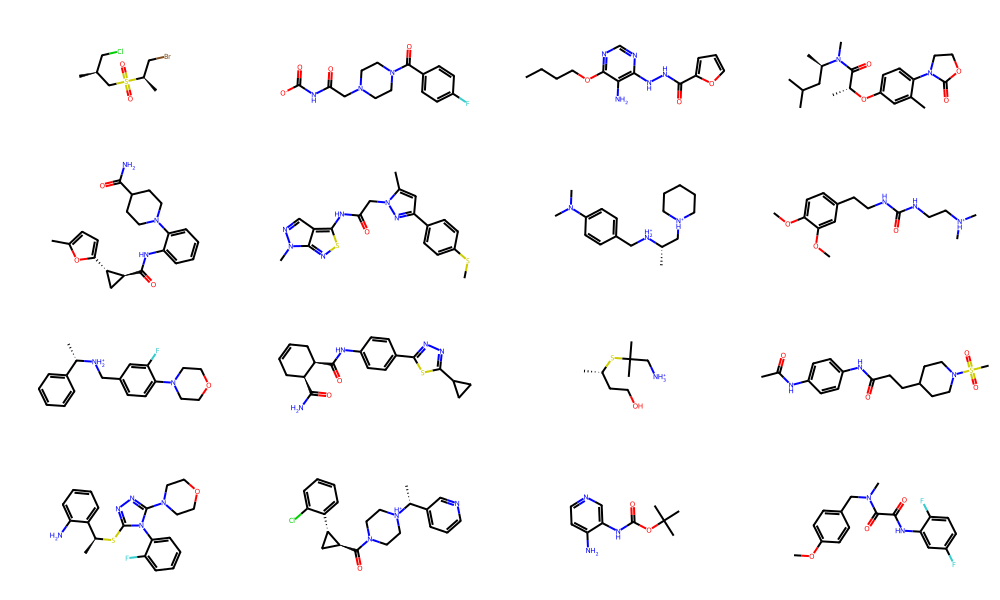

In [22]:
model.eval()
sample_smis = sample.take_samples(model, n_batch)
valid_rate = visual_mols(sample_smis)

In [69]:
loader = gen_loader(test[:50000])

for idx, (i, j) in enumerate(loader):
    z, mu, _ = model.forward_encoder(i)
    if idx == 0:
        new_mu = mu
        new_label = j
    else:
        new_mu = torch.cat([new_mu, mu], dim=0)
        new_label = torch.cat([new_label, j], dim=0)
print(new_mu.shape, new_label.shape)


---> calculating QED
---> calculating SA 
loader finished
torch.Size([49891, 256]) torch.Size([49891, 2])


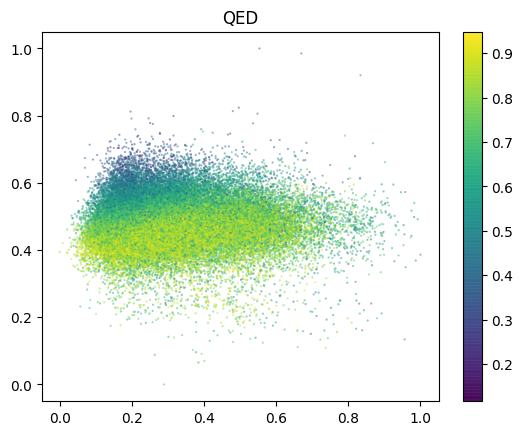

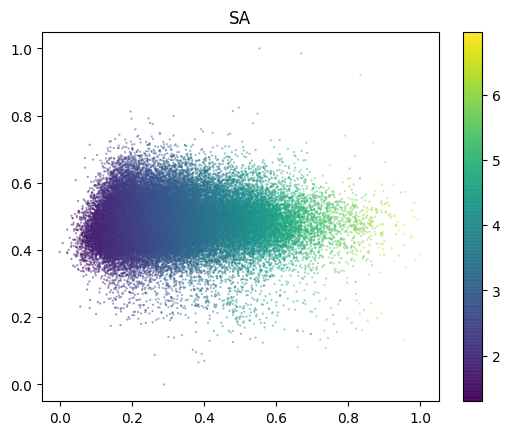

In [71]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

# do pca and normalize
Z_pca = PCA(n_components=2).fit_transform(new_mu.cpu().detach().numpy())
Z_pca = MinMaxScaler().fit_transform(Z_pca)
df = pd.DataFrame(np.transpose((Z_pca[:,0],Z_pca[:,1])))
df.columns = ['x','y']
props = pd.DataFrame(new_label.cpu().detach().numpy(), columns=['QED', 'SA'])
df['QED'] = props['QED']
df['SA'] = props['SA']
for prop_opt in ['QED', 'SA']:
    df[prop_opt]= props[prop_opt]

    plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    cbar = plt.colorbar()
    cbar.solids.set_edgecolor("face")
    # draw()
    plt.title(prop_opt)
    plt.show()


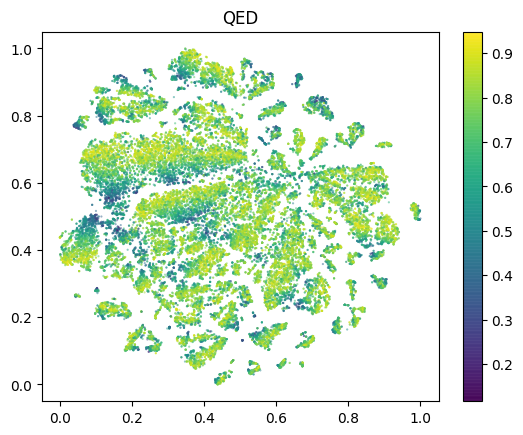

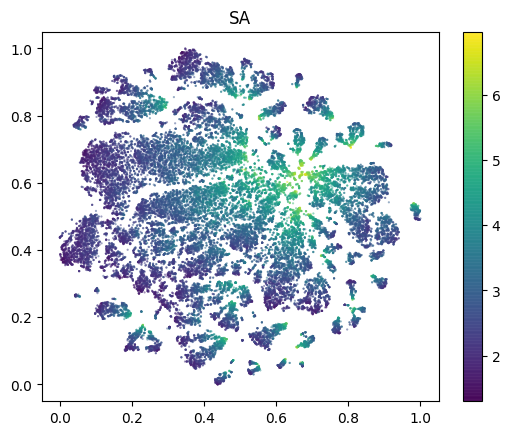

In [72]:
from sklearn.manifold import TSNE

Z_tsne = TSNE(n_components=2).fit_transform(new_mu.cpu().detach().numpy())
Z_tsne = MinMaxScaler().fit_transform(Z_tsne)
df = pd.DataFrame(np.transpose((Z_tsne[:,0],Z_tsne[:,1])))
df.columns = ['x','y']
for prop_opt in ['QED', 'SA']:
    df[prop_opt]= props[prop_opt]

    plt.scatter(x=df['x'], y=df['y'], c=df[prop_opt],
                cmap= 'viridis', marker='.',
                s=10,alpha=0.5, edgecolors='none')
    cbar = plt.colorbar()
    cbar.solids.set_edgecolor("face")
    # draw()
    plt.title(prop_opt)
    plt.show()
